In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

#pip install gym
#pip install gym-toytext

In [2]:
env = gym.make('FrozenLake-v1',render_mode="rgb_array_list")
env.reset()

(0, {'prob': 1})

In [3]:
num_states = env.observation_space.n
num_actions = env.action_space.n
print(env.observation_space)
print(env.action_space)

Discrete(16)
Discrete(4)


In [4]:
# print(env.P[0][0])
#contains the state transition probabilities in form of dictonary(key:value pairs)


#[P_s,a->s' probabiliy of going to s' given current state is s and action taken is a, s' , R(s') reward after transition ,going to terminal value 
env.P

{0: {0: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  2: [(0.3333333333333333, 4, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)],
  3: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 1: {0: [(0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True)],
  1: [(0.3333333333333333, 0, 0.0, False),
   (0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False)],
  2: [(0.3333333333333333, 5, 0.0, True),
   (0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False)],
  3: [(0.3333333333333333, 2, 0.0, False),
   (0.3333333333333333, 1, 0.0, False),
   (0.3333333333333333, 0, 0.0, False)]},
 2:

<p>To modify the reward function such that the holes have a reward of -1, the goal has a reward of +1, and the frozen parts have a penalty of -0.01 to encourage the RL agent to reach the goal faster, you can make the following changes to your code:</p>

In [5]:
state_reward = np.zeros(num_states) #creating an array of reward for eay access of state rewards
terminal_state = np.zeros(num_states)

for i in range(num_states):
    for j in range(num_actions):
        for k in range(len(env.P[i][j])):
            prob,state,reward,terminal = env.P[i][j][k]
            if( terminal == True):
                terminal_state[state] = 1
            if( terminal == True and abs(reward-0.0) < 1e-3 ):
                if(state == 15):
                    env.P[i][j][k] = (prob,state,1.0,terminal)
                else:
                    env.P[i][j][k] = (prob,state,-1.0,terminal)
                    
            if( terminal == False and abs(reward-0.0) < 1e-3 and state != 0 ):#fronzen part 
                env.P[i][j][k] = (prob,state,-0.01,terminal)
            state_reward[state] =  env.P[i][j][k][2]

print(state_reward.reshape(4,4))
print(terminal_state.reshape(4,4))

[[ 0.   -0.01 -0.01 -0.01]
 [-0.01 -1.   -0.01 -1.  ]
 [-0.01 -0.01 -0.01 -1.  ]
 [-1.   -0.01 -0.01  1.  ]]
[[0. 0. 0. 0.]
 [0. 1. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 1.]]


Text(0.5, 1.0, 'Value Iteration')

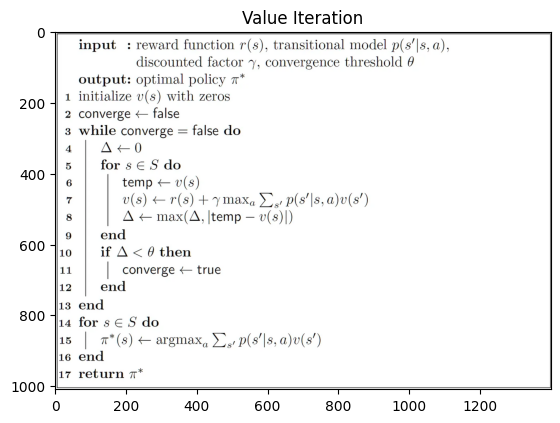

In [6]:
img = cv2.imread("valueiteralgo.webp")
plt.imshow(img)
plt.title('Value Iteration')

In [7]:
class valueiteration():        
    def __init__(self,env,max_epochs = 1000,epsilon = 1e-10):
        self.env = env
        self.max_epochs = max_epochs
        self.epsilon = epsilon
        self.state_value = np.zeros(env.observation_space.n)
        self.num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.optimal_state_action = np.zeros(self.num_states)
        
    
    def findpolicy(self):
        #given optimal state_values we can find optimal policy
        optimal_action = np.zeros(self.num_states)*-1
        for i in range(self.num_states):
            actions = np.zeros(self.num_actions)
            for j in range(self.num_actions):
                gain = 0
                for k in self.env.P[i][j]:
                    gain += k[0]*self.state_value[k[1]]
                actions[j] = gain
            optimal_action[i] = np.argmax(actions)
       
        # Plotting the heatmap
        sns.heatmap(self.state_value.reshape(4,4), cmap='Blues', annot=True, fmt='.2f')
        self.optimal_state_action = optimal_action
        action = optimal_action.reshape(4,4)
        print(action)
        action = action.T
        for i in range(4):
            for j in range(4):
                if(terminal_state[j*4 + i]): # as the matrix is transposed due to plt.arrow characteristics
                    continue
                move = action[i][j]
                dx,dy = 0,0
                if move == 0:  # Move left
                    dx = 0.3
                elif move == 1:  # Move down
                    dy = 0.3
                elif move == 2:  # Move right
                    dx = -0.3
                elif move == 3:  # Move up
                    dy = -0.3
                #  arrow top left is origin
                plt.arrow(i + 0.5,j + 0.5, dx, dy, width=0.02, head_width=0.15, head_length=0.15, fc='black', ec='black')

        plt.show()
           
        
    def iteration(self,gamma):
        initial = self.state_value.copy()
        for i in range(self.num_states):
            temp = self.state_value[i]
            actions = np.zeros(self.num_actions)
            for j in range(self.num_actions):
                summation = 0.0
                for k in self.env.P[i][j]: # each k is a tuple
                    summation += k[0]*self.state_value[k[1]]
                actions[j] = summation
            self.state_value[i] = state_reward[i] + gamma*np.max(actions) #update statement
            
        return np.linalg.norm(initial - self.state_value)
                         
        
    def train(self,gamma):
        error = []
        delta = self.iteration(gamma)
        epochs = 1
        error.append(delta)
        while delta > self.epsilon:
            delta = self.iteration(gamma)
            epochs += 1
            error.append(delta)
            
        #plotting convergence
        print(f'Noof epochs {epochs}')
        plt.figure(figsize=(4, 4))
        x_vals = range(epochs)
        plt.plot(x_vals, error)
        plt.xlabel('Epochs')
        plt.ylabel('change in state value')
        plt.grid()
        plt.title(f'Error Convergence with gamma as {gamma}')
        plt.show()      

Noof epochs 36


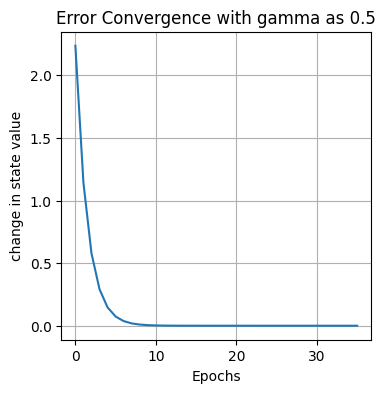

[[0. 3. 3. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


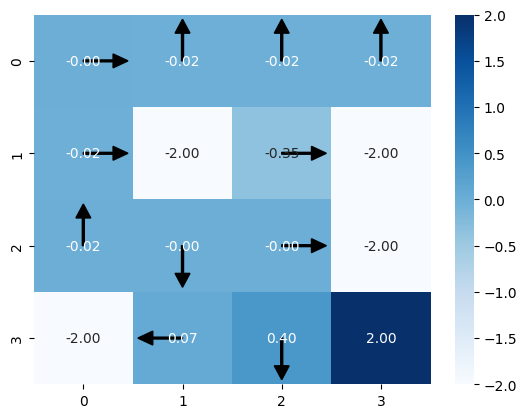

In [8]:
model = valueiteration(env)
model.train(0.5)
model.findpolicy()

<p>In the value iteration algorithm, the discount factor determines the importance of future rewards relative to immediate rewards. It controls how much weight is given to future state-action pairs when updating the state values.Decreasing the discount factor makes the algorithm more focused on immediate rewards, leading to faster convergence. However, it may also result in suboptimal long-term policies, as the algorithm may not fully consider the potential benefits of future actions.</p>

<p>As the model is not too complex both results in same optimal solution</p>

Noof epochs 227


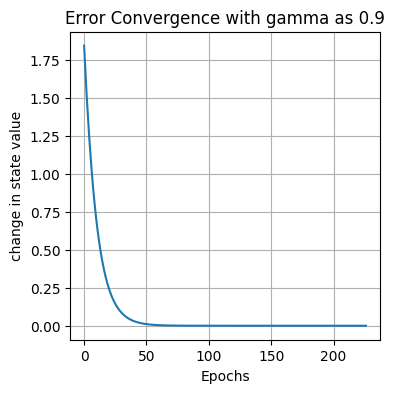

[[0. 3. 3. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


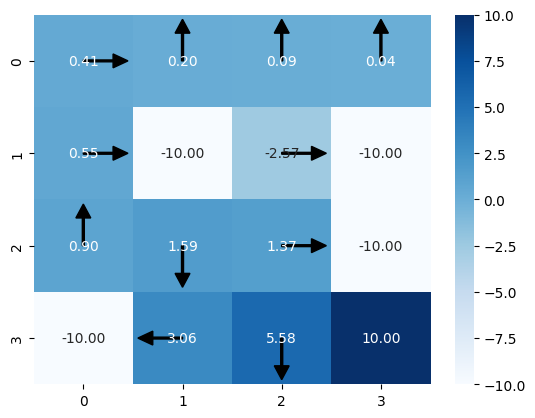

In [9]:
model.train(0.9)
model.findpolicy()

In [10]:
# step returns the 5-tuple (observation, reward, terminated, False, info).
#caution macos is not suppoting rendering causing jupyter kernal to shutdown

# import time

# def render(env, optimal_state_action):
#     state = 0
#     done = False
#     while not done:
#         action = optimal_state_action[state]
#         state, _, done, _,_ = env.step(int(action))
#         env.render() 
#         time.sleep(2)
    
#     env.close()

    
# render(model.env, model.optimal_state_action)
